In [1]:
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from contextlib import contextmanager
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import itertools
import time
import math
import gc
import os
import re


warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_csv('/media/ismaeel/Work/msds19029_thesis/dataset/home_with_missing.csv')

In [3]:
data.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,FLOORSMAX_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,WALLSMATERIAL_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_8,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT,DOCUMENT_COUNT,NEW_DOC_KURT,AGE_RANGE,EXT_SOURCES_PROD,EXT_SOURCES_WEIGHTED,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,CREDIT_TO_INCOME_RATIO,INCOME_TO_EMPLOYED_RATIO,INCOME_TO_BIRTH_RATIO,EMPLOYED_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,GROUP_EXT_SOURCES_MEDIAN,GROUP_EXT_SOURCES_STD,GROUP_INCOME_MEAN,GROUP_INCOME_STD,GROUP_CREDIT_TO_ANNUITY_MEAN,GROUP_CREDIT_TO_ANNUITY_STD,GROUP_CREDIT_MEAN,GROUP_ANNUITY_MEAN,GROUP_ANNUITY_STD,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MEAN,BUREAU_DEBT_CREDIT_DIFF_MEAN,BUREAU_DEBT_CREDIT_DIFF_SUM,BUREAU_MONTHS_BALANCE_MEAN_MEAN,BUREAU_MONTHS_BALANCE_MEAN_VAR,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_STATUS_0_MEAN,BUREAU_STATUS_1_MEAN,BUREAU_STATUS_12345_MEAN,BUREAU_STATUS_C_MEAN,BUREAU_STATUS_X_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_LL_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LL_DEBT_CREDIT_DIFF_MEAN,BUREAU_LL_STATUS_12345_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_MAX,BUREAU_ACTIVE_DAYS_CREDIT_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN,BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN,BUREAU_ACTIVE_CREDIT_TO_ANNUITY_RATIO_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_VAR,BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_SUM,BUREAU_CLOSED_DAYS_CREDIT_MAX,BUREAU_CLOSED_DAYS_CREDIT_VAR,BUREAU_CLOSED_DAYS_CREDIT_ENDDATE_MAX,BUREAU_CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_CLOSED_AMT_CREDIT_SUM_MAX,BUREAU_CLOSED_AMT_CREDIT_SUM_MEAN,BUREAU_CLOSED_AMT_CREDIT_SUM_SUM,BUREAU_CLOSED_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_CLOSED_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_CLOSED_DAYS_CREDIT_UPDATE_MAX,BUREAU_CLOSED_ENDDATE_DIF_MEAN,BURE

In [4]:
print(data['TARGET'].value_counts())
data = data.dropna(axis=0, subset=['TARGET'])
print(data['TARGET'].value_counts())

0.0    282682
1.0     24824
Name: TARGET, dtype: int64
0.0    282682
1.0     24824
Name: TARGET, dtype: int64


In [5]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [6]:
feature_name = missing_data[missing_data['Percent'] > 10]
data.drop(list(feature_name.index), axis=1, inplace=True)
print(f"Feature Count: {data.shape[1]}")

Feature Count: 256


In [7]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [8]:
feature_name = missing_data[missing_data['Percent'] != 0]
data = data.dropna(axis=0, subset=list(feature_name.index))
print(f"Feature Count: {data.shape[1]}")

Feature Count: 256


In [9]:
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [18]:
Y = data['TARGET']
X = data
train, test, __, __ = train_test_split(X, Y, test_size=0.10, random_state=42)

In [54]:
def kfold_lightgbm_sklearn(train, test, categorical_feature = None):
    print("Train/valid shape: {}, test shape: {}".format(train.shape, test.shape))
    del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
    predictors = list(filter(lambda v: v not in del_features, train.columns))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(train.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[predictors], train['TARGET'])):
        train_x, train_y = train[predictors].iloc[train_idx], train['TARGET'].iloc[train_idx]
        valid_x, valid_y = train[predictors].iloc[valid_idx], train['TARGET'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(train[predictors].columns), categorical_feature= categorical_feature)
        clf.booster_.save_model('/media/ismaeel/Work/msds19029_thesis/home credit/LGBM.txt')
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        
        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train['TARGET'], oof_preds))

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    # Save feature importance, test predictions and oof predictions as csv
    mean_importance.to_csv('/media/ismaeel/Work/msds19029_thesis/home credit/feature_importance_lgbm.csv', index=False)
    return mean_importance

In [55]:
# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_FOLDS = 10
EARLY_STOPPING = 100
NUM_THREADS = 4

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

In [56]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

In [57]:
lgbm_categorical_feat = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']
with timer("Run LightGBM"):
    feat_importance = kfold_lightgbm_sklearn(train, test, lgbm_categorical_feat)
    print(feat_importance)

Train/valid shape: (239818, 256), test shape: (26647, 256)


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.795392	training's binary_logloss: 0.24031	valid_1's auc: 0.761035	valid_1's binary_logloss: 0.248547
[800]	training's auc: 0.822707	training's binary_logloss: 0.228395	valid_1's auc: 0.770386	valid_1's binary_logloss: 0.243894
[1200]	training's auc: 0.842106	training's binary_logloss: 0.220336	valid_1's auc: 0.774449	valid_1's binary_logloss: 0.242253
[1600]	training's auc: 0.858746	training's binary_logloss: 0.213487	valid_1's auc: 0.776624	valid_1's binary_logloss: 0.241466
[2000]	training's auc: 0.873305	training's binary_logloss: 0.207376	valid_1's auc: 0.777773	valid_1's binary_logloss: 0.24107
[2400]	training's auc: 0.886369	training's binary_logloss: 0.201732	valid_1's auc: 0.778227	valid_1's binary_logloss: 0.240935
[2800]	training's auc: 0.897834	training's binary_logloss: 0.196532	valid_1's auc: 0.778498	valid_1's binary_logloss: 0.240842
Early stopping, best iteration is:
[2737]	training's 

/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.793723	training's binary_logloss: 0.240514	valid_1's auc: 0.772155	valid_1's binary_logloss: 0.24736
[800]	training's auc: 0.820974	training's binary_logloss: 0.228719	valid_1's auc: 0.78325	valid_1's binary_logloss: 0.241752
[1200]	training's auc: 0.840813	training's binary_logloss: 0.220644	valid_1's auc: 0.78794	valid_1's binary_logloss: 0.239693
[1600]	training's auc: 0.857659	training's binary_logloss: 0.213811	valid_1's auc: 0.790166	valid_1's binary_logloss: 0.238774
[2000]	training's auc: 0.872316	training's binary_logloss: 0.207738	valid_1's auc: 0.791153	valid_1's binary_logloss: 0.238313
[2400]	training's auc: 0.885437	training's binary_logloss: 0.202112	valid_1's auc: 0.791799	valid_1's binary_logloss: 0.238103
[2800]	training's auc: 0.897146	training's binary_logloss: 0.196888	valid_1's auc: 0.792095	valid_1's binary_logloss: 0.237957
Early stopping, best iteration is:
[3022]	training's a

/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.79509	training's binary_logloss: 0.240322	valid_1's auc: 0.767725	valid_1's binary_logloss: 0.247847
[800]	training's auc: 0.821957	training's binary_logloss: 0.228544	valid_1's auc: 0.778068	valid_1's binary_logloss: 0.242722
[1200]	training's auc: 0.841692	training's binary_logloss: 0.220428	valid_1's auc: 0.782497	valid_1's binary_logloss: 0.240883
[1600]	training's auc: 0.858303	training's binary_logloss: 0.213609	valid_1's auc: 0.78485	valid_1's binary_logloss: 0.239977
[2000]	training's auc: 0.87291	training's binary_logloss: 0.207522	valid_1's auc: 0.785701	valid_1's binary_logloss: 0.239627
[2400]	training's auc: 0.885938	training's binary_logloss: 0.201911	valid_1's auc: 0.78628	valid_1's binary_logloss: 0.239407
Early stopping, best iteration is:
[2448]	training's auc: 0.887378	training's binary_logloss: 0.201268	valid_1's auc: 0.786407	valid_1's binary_logloss: 0.239364
Fold  3 AUC : 0.7864

/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.795601	training's binary_logloss: 0.240047	valid_1's auc: 0.755668	valid_1's binary_logloss: 0.250114
[800]	training's auc: 0.822634	training's binary_logloss: 0.228213	valid_1's auc: 0.765974	valid_1's binary_logloss: 0.245773
[1200]	training's auc: 0.842247	training's binary_logloss: 0.22011	valid_1's auc: 0.770122	valid_1's binary_logloss: 0.244314
[1600]	training's auc: 0.858788	training's binary_logloss: 0.213292	valid_1's auc: 0.772343	valid_1's binary_logloss: 0.243594
[2000]	training's auc: 0.873405	training's binary_logloss: 0.207193	valid_1's auc: 0.773529	valid_1's binary_logloss: 0.243222
[2400]	training's auc: 0.886459	training's binary_logloss: 0.201602	valid_1's auc: 0.774209	valid_1's binary_logloss: 0.243021
Early stopping, best iteration is:
[2378]	training's auc: 0.885816	training's binary_logloss: 0.201891	valid_1's auc: 0.774227	valid_1's binary_logloss: 0.24302
Fold  4 AUC : 0.77

/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.795036	training's binary_logloss: 0.240491	valid_1's auc: 0.760353	valid_1's binary_logloss: 0.24606
[800]	training's auc: 0.821675	training's binary_logloss: 0.228747	valid_1's auc: 0.772505	valid_1's binary_logloss: 0.241084
[1200]	training's auc: 0.841512	training's binary_logloss: 0.220627	valid_1's auc: 0.777687	valid_1's binary_logloss: 0.239197
[1600]	training's auc: 0.858037	training's binary_logloss: 0.213829	valid_1's auc: 0.78011	valid_1's binary_logloss: 0.238334
[2000]	training's auc: 0.872451	training's binary_logloss: 0.207741	valid_1's auc: 0.781461	valid_1's binary_logloss: 0.237882
[2400]	training's auc: 0.885635	training's binary_logloss: 0.202109	valid_1's auc: 0.782245	valid_1's binary_logloss: 0.237605
[2800]	training's auc: 0.89721	training's binary_logloss: 0.196896	valid_1's auc: 0.782859	valid_1's binary_logloss: 0.237402
Early stopping, best iteration is:
[2953]	training's a

/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.794393	training's binary_logloss: 0.240216	valid_1's auc: 0.761784	valid_1's binary_logloss: 0.250097
[800]	training's auc: 0.821577	training's binary_logloss: 0.228414	valid_1's auc: 0.775294	valid_1's binary_logloss: 0.244549
[1200]	training's auc: 0.841193	training's binary_logloss: 0.220323	valid_1's auc: 0.781014	valid_1's binary_logloss: 0.242473
[1600]	training's auc: 0.857832	training's binary_logloss: 0.213541	valid_1's auc: 0.783933	valid_1's binary_logloss: 0.241454
[2000]	training's auc: 0.872461	training's binary_logloss: 0.207482	valid_1's auc: 0.785443	valid_1's binary_logloss: 0.240936
[2400]	training's auc: 0.885409	training's binary_logloss: 0.20193	valid_1's auc: 0.786461	valid_1's binary_logloss: 0.240607
[2800]	training's auc: 0.896977	training's binary_logloss: 0.196741	valid_1's auc: 0.787082	valid_1's binary_logloss: 0.240351
Early stopping, best iteration is:
[2796]	training's

/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.79454	training's binary_logloss: 0.239873	valid_1's auc: 0.763216	valid_1's binary_logloss: 0.252639
[800]	training's auc: 0.822029	training's binary_logloss: 0.22805	valid_1's auc: 0.775212	valid_1's binary_logloss: 0.247281
[1200]	training's auc: 0.841644	training's binary_logloss: 0.21997	valid_1's auc: 0.780123	valid_1's binary_logloss: 0.245377
[1600]	training's auc: 0.858203	training's binary_logloss: 0.213173	valid_1's auc: 0.782613	valid_1's binary_logloss: 0.244426
[2000]	training's auc: 0.87287	training's binary_logloss: 0.207102	valid_1's auc: 0.783888	valid_1's binary_logloss: 0.243983
[2400]	training's auc: 0.885758	training's binary_logloss: 0.201532	valid_1's auc: 0.78448	valid_1's binary_logloss: 0.243734
[2800]	training's auc: 0.897209	training's binary_logloss: 0.196328	valid_1's auc: 0.785101	valid_1's binary_logloss: 0.243539
Early stopping, best iteration is:
[3070]	training's auc

/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.795044	training's binary_logloss: 0.240406	valid_1's auc: 0.765388	valid_1's binary_logloss: 0.246625
[800]	training's auc: 0.822389	training's binary_logloss: 0.228562	valid_1's auc: 0.777362	valid_1's binary_logloss: 0.241357
[1200]	training's auc: 0.842123	training's binary_logloss: 0.220471	valid_1's auc: 0.782316	valid_1's binary_logloss: 0.239347
[1600]	training's auc: 0.858759	training's binary_logloss: 0.213636	valid_1's auc: 0.78495	valid_1's binary_logloss: 0.238344
[2000]	training's auc: 0.873303	training's binary_logloss: 0.207539	valid_1's auc: 0.786332	valid_1's binary_logloss: 0.237847
[2400]	training's auc: 0.886026	training's binary_logloss: 0.202003	valid_1's auc: 0.7869	valid_1's binary_logloss: 0.237595
[2800]	training's auc: 0.897441	training's binary_logloss: 0.196832	valid_1's auc: 0.787508	valid_1's binary_logloss: 0.237351
[3200]	training's auc: 0.907691	training's binary_logl

/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.794458	training's binary_logloss: 0.240406	valid_1's auc: 0.768737	valid_1's binary_logloss: 0.247516
[800]	training's auc: 0.821658	training's binary_logloss: 0.228555	valid_1's auc: 0.778148	valid_1's binary_logloss: 0.242865
[1200]	training's auc: 0.841212	training's binary_logloss: 0.22045	valid_1's auc: 0.781786	valid_1's binary_logloss: 0.241392
[1600]	training's auc: 0.857986	training's binary_logloss: 0.213632	valid_1's auc: 0.783983	valid_1's binary_logloss: 0.240618
[2000]	training's auc: 0.872703	training's binary_logloss: 0.207497	valid_1's auc: 0.784691	valid_1's binary_logloss: 0.240319
[2400]	training's auc: 0.885619	training's binary_logloss: 0.201943	valid_1's auc: 0.784987	valid_1's binary_logloss: 0.240164
Early stopping, best iteration is:
[2405]	training's auc: 0.885768	training's binary_logloss: 0.20188	valid_1's auc: 0.785026	valid_1's binary_logloss: 0.240152
Fold  9 AUC : 0.78

/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/media/ismaeel/Work/msds19029_thesis/env/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[400]	training's auc: 0.794624	training's binary_logloss: 0.240468	valid_1's auc: 0.762902	valid_1's binary_logloss: 0.246666
[800]	training's auc: 0.821789	training's binary_logloss: 0.228682	valid_1's auc: 0.772845	valid_1's binary_logloss: 0.241945
[1200]	training's auc: 0.841506	training's binary_logloss: 0.220561	valid_1's auc: 0.777274	valid_1's binary_logloss: 0.240161
[1600]	training's auc: 0.858026	training's binary_logloss: 0.213752	valid_1's auc: 0.779571	valid_1's binary_logloss: 0.239279
[2000]	training's auc: 0.872495	training's binary_logloss: 0.207697	valid_1's auc: 0.780923	valid_1's binary_logloss: 0.238789
[2400]	training's auc: 0.885592	training's binary_logloss: 0.202119	valid_1's auc: 0.781781	valid_1's binary_logloss: 0.238476
Early stopping, best iteration is:
[2559]	training's auc: 0.890305	training's binary_logloss: 0.200012	valid_1's auc: 0.78209	valid_1's binary_logloss: 0.238368
Fold 10 AUC : 0.7

In [11]:
def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    Returns
    -------     
    list type, with optimal cutoff value
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']) 

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [12]:
model = lgb.Booster(model_file='/media/ismaeel/Work/msds19029_thesis/home credit/LGBM.txt')
feats = [f for f in train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [13]:
test = train[feats]
labels = train['TARGET']

pred = model.predict(test)
th = find_optimal_cutoff(labels, pred)
pred = np.where(pred > th, 1, 0)
cm = confusion_matrix(labels, pred)

In [14]:
cr = classification_report(labels, pred, target_names=['Approved', 'Declined'])
print(cr)

              precision    recall  f1-score   support

    Approved       0.98      0.80      0.88    220280
    Declined       0.26      0.80      0.39     19538

    accuracy                           0.80    239818
   macro avg       0.62      0.80      0.63    239818
weighted avg       0.92      0.80      0.84    239818



Binary: ROC AUC=0.797


<function matplotlib.pyplot.show(close=None, block=None)>

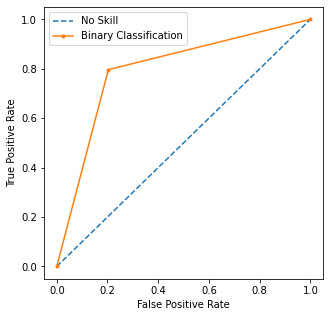

In [15]:
ns_probs = [0 for _ in range(len(labels))]
ns_auc = roc_auc_score(labels, ns_probs)
lr_auc = roc_auc_score(labels, pred)
print('Binary: ROC AUC=%.3f' % (lr_auc))
plt.figure(figsize=(5, 5))
ns_fpr, ns_tpr, th1 = roc_curve(labels, ns_probs)
lr_fpr, lr_tpr, th2 = roc_curve(labels, pred)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Binary Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show

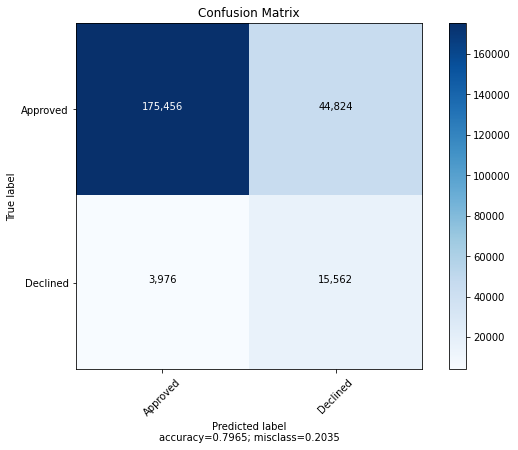

In [16]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Approved', 'Declined'],
                      title        = "Confusion Matrix")

In [19]:
input_ = test[feats]
labels = test['TARGET']

pred = model.predict(input_)
th = find_optimal_cutoff(labels, pred)
pred = np.where(pred > th, 1, 0)
cm = confusion_matrix(labels, pred)

In [20]:
cr = classification_report(labels, pred, target_names=['Approved', 'Declined'])
print(cr)

              precision    recall  f1-score   support

    Approved       0.97      0.72      0.83     24453
    Declined       0.19      0.72      0.30      2194

    accuracy                           0.72     26647
   macro avg       0.58      0.72      0.56     26647
weighted avg       0.90      0.72      0.78     26647



Binary: ROC AUC=0.722


<function matplotlib.pyplot.show(close=None, block=None)>

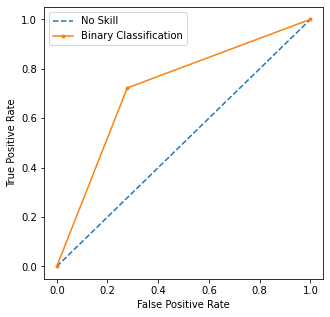

In [21]:
ns_probs = [0 for _ in range(len(labels))]
ns_auc = roc_auc_score(labels, ns_probs)
lr_auc = roc_auc_score(labels, pred)
print('Binary: ROC AUC=%.3f' % (lr_auc))
plt.figure(figsize=(5, 5))
ns_fpr, ns_tpr, th1 = roc_curve(labels, ns_probs)
lr_fpr, lr_tpr, th2 = roc_curve(labels, pred)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Binary Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show

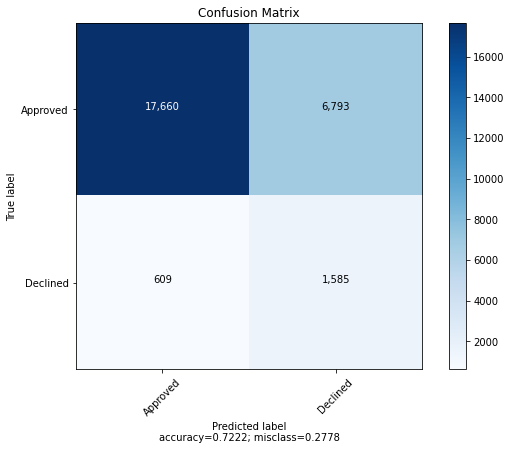

In [22]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Approved', 'Declined'],
                      title        = "Confusion Matrix")